In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

Consider the Boltzmann distribution 
$$\rho(x)=\frac 1Z \exp(-\beta V(x))$$

where $$Z=\int_{-\infty}^\infty \exp(-\beta V(x))dx$$

is the partition function.

Often of relevance and importance to physicists, the partition function is useful to evaluate. In fact, by computing it we are able to determine the expected value and variance of the Boltzmann distribution. The distribution occurs often in statistical mechanics and other areas, and can be difficult to deal with, particularly when prented in multiple dimensions.

Our goal is to come up with a way to sample from the Boltzmann distribution, which is a nontrivial task when the underlying energy potential function is complicated (such a quartic polynomial in two dimensions). In order to achieve this, we'll use the Metropolis-Hastings algorithm. 

Then, we wish to able to numerically estimate the value of $Z$, our partition function. To this end, we'll employ Skilling's Nested Sampling algorithm, a consequence of a very clever interpretation of Bayesian statistics. 

Let's first test proof of concept with a rather simple energy function $V(x)=(x^2-1)^2$

In [2]:
#energy potential and likelihood functions
def V(x):
    return (x**2-1)**2

β=10

def f(x):
    return np.exp(-β*V(x))

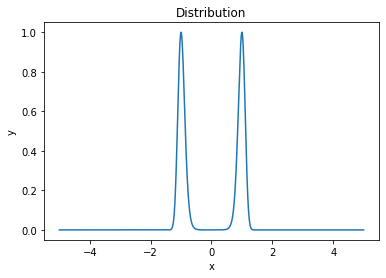

In [115]:
#plotting landscape
x = np.linspace(-5, 5, 10000)
plt.plot(x,f(x))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Distribution')
plt.show()

We'll use the Metropolis-Hastings Algorithm to sample from this distribution. Recall that we don't need to know the value of $Z$ for this, which is advantageous since that is frequently the case in practice.

In [119]:
#metropolis hastings

np.random.seed(100)
n_iters=10**4
σ=1
#random sampling from the distribution.
def MCMC(x0):
    xt=np.linspace(0,0,n_iters)
    n=1
    for n in range(0,n_iters):
        xp=x0+σ*np.random.normal()
        a=min(1, f(xp)/f(x0))
        ζ=np.random.rand()
    
        if (a>ζ):
            x0=xp
        xt[n]=x0
    return xt[n_iters-1]

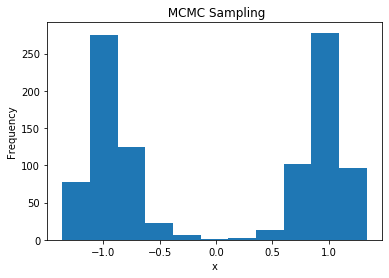

In [162]:
#check to make sure distribution is accurate
xt=[MCMC(0) for i in range(0,1000)]
plt.hist(xt,bins='auto')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title(' MCMC Sampling of the Energy Potential')
plt.show()

As we can see, the MCMC algorithm accurately estimates the distribution plotted above.

Here we employ Skilling's nested sampling algorithm to estimate the partition function $Z$. Recall that this is a computation of a point estimator, which is a random variable. Thus, we do this multiple times and take an average to reduce variance.

In [121]:
#nested sampling to compute evidence Z
def Skil(N):
    #N=1000
    X0=1
    Z=0
    NS=[np.random.rand() for i in range (0,N)] #get some samples from prior
    Lik=[f(NS[i]) for i in range (0,N)] #Calculate Likelihood
    for i in range(1,50): #Skilling's algorithm for computing Z
        Li=min(Lik)
        L=Lik.index(Li)
        Lik.remove(Li)
        NS.remove(NS[L])
        Xi=np.exp(-i/N)
        wi=(X0-Xi)
        X0=Xi
        Z+=Li*wi
        
        Np=MCMC(NS[np.random.randint(N-1)])
        
        NS.append(Np)
        
        Lik.append(f(Np))
    Z+=(1/N) * sum(Lik)*Xi #upon termination, add an approximation of leftover area
    return Z


In [122]:
#plot a distribution of Z
ans, err=integrate.quad(f,-np.inf,np.inf)
np.random.seed(100)
Zd=[Skil(10) for i in range(1,10)]

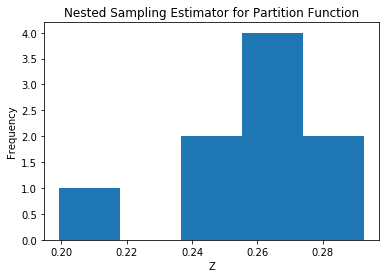

0.25908691333877987

In [129]:
plt.hist(Zd,bins='auto')
plt.xlabel('Z')
plt.ylabel('Frequency')
plt.title('Nested Sampling Estimator for Partition Function')
plt.show()
np.mean(Zd)

Thus we have an estimate of $Z$. Since this is a simple function, we can compute this using a numerical technique known as integration by quadrature, and find that our result is actually quite close! 

Below, we apply the same techniques to a much more complicated two dimensional energy function, which is of further relevance.

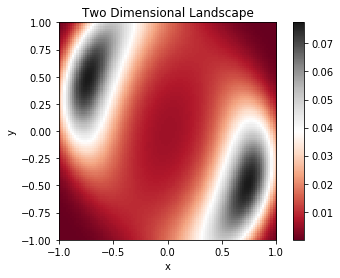

In [138]:
#energy potential and likelihood functions
def V2(x,y):
    return 1/36 * (4 * (-x**2-y**2)**2 + 2 *(x**2-2)**2
    + ((x+y)**2 - 2 )**2+ ((x-y)**2 - 5 )**2)

β=5

def f2(x,y):
    return np.exp(-β*V2(x,y))

#plotting landscape
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1, 1, 100)
X,Y=np.meshgrid(x,y)
Z=f2(X,Y)
#plt.contour(X,Y,Z,20,cmap='RdGy')
#plt.colorbar()

plt.imshow(Z, extent=[-1, 1,-1, 1], origin='lower',
           cmap='RdGy')
plt.colorbar()
plt.axis(aspect='image');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two Dimensional Landscape')
plt.show()

Above, we can see a plot of the rather complex landscape achieved by this two dimensional bi-modal distribution, which in practice is difficult to sample from.

In [133]:
#metropolis hastings

np.random.seed(1000)

σ=1
n_iters=10**4

#random sampling from the distribution.
def MCMC2(x0,y0):
    t=1
    xt=np.linspace(0,0,n_iters)
    yt=np.linspace(0,0,n_iters)
    for n in range(0,n_iters):
        xp=x0+σ*np.random.normal()
        yp=y0+σ*np.random.normal()
        T=[1,float(f2(xp,yp)/f2(x0,y0))]
        T=np.asarray(T)
        
        a=np.min(T.tolist())
        #Temp=np.array(1,float(f2(xp,yp)/f2(x0,y0)))
        #Temp=np.asarray(Temp)
        #a=np.amin(Temp)
        ζ=np.random.rand()
        
        
        #if isinstance(T[1], np.ndarray)==True:
         #   print("woops")
         #   break
        if (a>ζ):
            x0=xp
            y0=yp
        xt[n]=x0
        yt[n]=y0
        
    
    return xt,yt

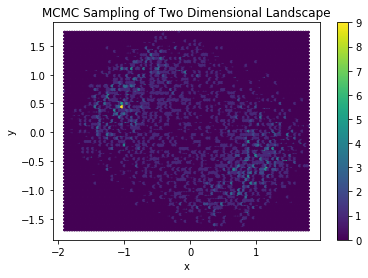

In [158]:
np.random.seed(100)
Xt,Yt=MCMC2(0,0)
XY=np.meshgrid(Xt,Yt)
#plt.scatter(Xt,Yt)
plt.hexbin(Xt,Yt,bins=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('MCMC Sampling of Two Dimensional Landscape')
plt.colorbar()
plt.show()

Metropolis Hastings Monte Carlo again returns a promising depiction of the underlying distribution. Now, we proceed to estimate the partition function $Z$.

In [160]:
#nested sampling to compute evidence Z
#Skil2(N):
N=1000
X0=1
Z=0
N1=[np.random.rand() for i in range (0,N)]
N2=[np.random.rand() for i in range (0,N)] #get some samples from prior
Lik=[f2(N1[i],N2[i]) for i in range (0,N)] #Calculate Likelihood
Lik=np.asarray(Lik)
for i in range(1,10): #Skilling's algorithm for computing Z
    
    Li=min(Lik) #Find the minimum likelihood point
    
    L=Lik.tolist().index(Li) #Index of min like
    Lik.tolist().remove(Li) #remove this point
    N1.remove(N1[L]) #Remove this point
    N2.remove(N2[L])
        
    Xi=np.exp(-i/N) 
    wi=(X0-Xi) #weights
    X0=Xi
    Z+=Li*wi #increment our area calculation
        
    k=np.random.randint(N-1) #choose a random point to copy from remaining N-1
        
    Npx,Npy=MCMC2(N1[k],N2[k]) #vary it sufficiently to have a roughly IID point
        
    N1.append(Npx) #append the new point and its likelihood, and repeat
    N2.append(Npy)
        
    Lik.tolist().append(f2(Npx,Npy))
Z+=(1/N) * sum(Lik)*Xi #upon termination, add an approximation of leftover area
    #return Z


In [161]:
Z

0.011357099168110603

As demonstrated, Skilling's Nested Sampling algorithm is a powerful approach to problems like this. As the Boltzmann distribution is still of relevance today, especially as Boltzmann Machines become more popular, this algorithm will continue to be used in a variety of applications.